# Libraries

In [347]:
# Load libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import words,stopwords
from nltk.tokenize import word_tokenize

nltk.download('words')
nltk.download('punkt')

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_auc_score, roc_curve, classification_report,
    ConfusionMatrixDisplay
)

from imblearn.over_sampling import SMOTE
import joblib
import matplotlib.cm as cm

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

from imblearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, ConfusionMatrixDisplay

import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB

import time
from scikitplot.metrics import plot_roc_curve as auc_roc
from sklearn.model_selection import GridSearchCV


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Importing cleaned datasets

In [348]:
# Load cleaned dataset
df = pd.read_csv(r"Final_Data_Engineering_Data.csv")

# Display the first 5 entries of the DataFrame
df.head(5)

,Unnamed: 0,Sentiment,clean_text,translated_text,tokens,Mood
0,0,Neutral,our innovation lab officially open click learn...,innovation officially open click learn tech sc...,"['innovation', 'officially', 'open', 'click', ...",0
1,1,Neutral,now open aws asia pacific seoul region via are...,open pacific region,"['open', 'pacific', 'region']",0
2,2,Neutral,a beginners guide scaling million users amazon...,guide scaling million,"['guide', 'scaling', 'million']",0
3,3,Neutral,bridging aws azure environment via vpn via are...,bridging azure environment,"['bridging', 'azure', 'environment']",0
4,4,Neutral,elk aws elasticsearch service elasticbeanstalk...,service,['service'],0


This distribution is imbalanced for modeling because the classes (moods) are not represented equally.
- The 'Neutral' class significantly outweighs both the 'Positive' and 'Negative' classes. The imbalance is particularly notable between 'Neutral' and 'Negative', where 'Neutral' is about 12 times more frequent than 'Negative'.
- Such imbalances can lead to biased models that favor the majority class ('Neutral') and may perform poorly on the minority classes ('Positive' and 'Negative'). This is because the model might learn to predict the majority class more often, as it minimizes overall error but may fail to capture the patterns in the minority classes.
- Traditional performance metrics like accuracy can be misleading in imbalanced datasets, as a model predicting only the majority class could still achieve high accuracy.

To address this imbalance, techniques such as resampling (e.g. SMOTE), class weighting, or using specialized metrics (e.g. Precision, Recall,F1 score) should be considered to improve model performance across all classes.

In [349]:
df['Mood'].value_counts()

Mood
0    62006
1    26240
2     5214
Name: count, dtype: int64

C:\Users\admin\AppData\Local\Temp\ipykernel_21432\1427554676.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(mood_counts))


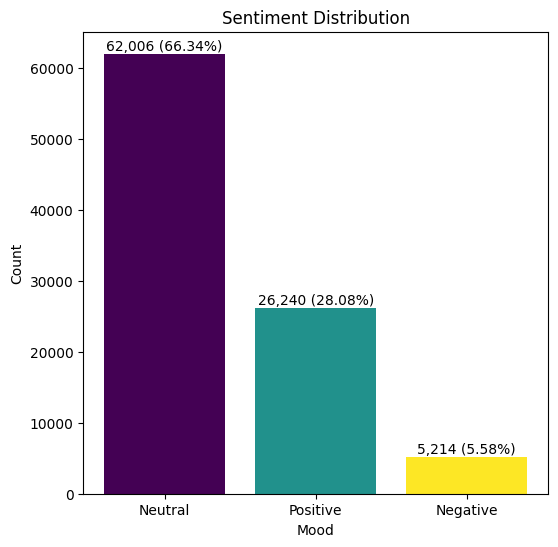

In [350]:
# Count the occurrences of each mood
mood_counts = df['Mood'].value_counts().sort_index()

# Map the mood numbers to labels
mood_labels = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}
mood_counts.index = mood_counts.index.map(mood_labels)

# Define colors using 'viridis' colormap
cmap = cm.get_cmap('viridis', len(mood_counts))
colors = [cmap(i) for i in range(len(mood_counts))]

# Calculate percentages
total_count = mood_counts.sum()
mood_percentages = (mood_counts / total_count) * 100

# Create a bar plot
plt.figure(figsize=(6, 6))
bars = plt.bar(mood_counts.index, mood_counts.values, color=colors)
plt.title('Sentiment Distribution')
plt.xlabel('Mood')
plt.ylabel('Count')

# Add value annotations on the bars with comma formatting and percentages
for bar, percentage in zip(bars, mood_percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height, f'{int(height):,} ({percentage:.2f}%)',
             ha='center', va='bottom')

plt.show()

# Splitting the data to training data and test data
- Set stratify=y in train_test_split, it ensures that the class distribution in the training and testing sets is the same as in the original dataset. For example, if your original dataset has 66% 'Neutral', 27% 'Positive', and 5% 'Negative' samples, the training and testing sets will also have approximately the same proportions of these classes.  This helps to ensure that the model is trained and tested on representative samples of the data, avoiding biases that could arise from having different class distributions in the training and testing sets. Avoiding biases means preventing the situation where the model might perform well on some classes but poorly on others due to imbalanced representation in the training or testing data.

In [351]:
# Vectorization
tfidf_vectorizer = TfidfVectorizer()
X = df['translated_text']
y = df['Mood']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Display shapes of the resulting datasets
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (74768,)
X_test shape: (18692,)
y_train shape: (74768,)
y_test shape: (18692,)


# How SMOTE (Synthetic Minority Over-sampling Technique) in our dataset:
- The number of examples for each mood is not equal. 'Neutral' has a lot more examples compared to 'Positive' and 'Negative'.
- When you train a machine learning model on this imbalanced data, the model can become biased. This means it might not learn to recognize 'Positive' and 'Negative' moods very well because it sees 'Neutral' much more often.
- SMOTE helps by creating new examples of the less common moods ('Positive' and 'Negative') to balance things out. It looks at the existing 'Positive' and 'Negative' examples and creates new, similar ones by mixing them together.
- By adding these new, synthetic examples to your dataset, SMOTE makes sure that each mood has roughly the same number of examples. This helps the machine learning model learn to recognize all moods equally well.
- synthetic example refers to a new, artificial data point that is generated to balance the dataset. 
- How it generate new data points: For each example in the minority class, SMOTE selects one or more of its nearest neighbors (other similar examples in the minority class).



In [352]:
# Applying tf idf to training and test data
X_train = X_train.fillna('')
X_test = X_test.fillna('')

X_train_tf = tfidf_vectorizer.fit_transform(X_train)
X_test_tf = tfidf_vectorizer.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tf, y_train)

# Convert resampled data back to text form
resampled_text = tfidf_vectorizer.inverse_transform(X_train_resampled)
resampled_text = [" ".join(text) for text in resampled_text]

# Create a DataFrame
resampled_df = pd.DataFrame({'translated_text': resampled_text, 'Mood': y_train_resampled})

print(f"Original shape: {df.shape}")
print(f"Resampled shape: {resampled_df.shape, y_train_resampled.shape}")

Original shape: (93460, 6)
Resampled shape: ((148815, 2), (148815,))


In [353]:
resampled_df['Mood'].value_counts()

Mood
0    49605
1    49605
2    49605
Name: count, dtype: int64

In [342]:
resampled_df.to_csv("balanced_dataset.csv",index=True)

Now, our training data is balanced, meaning it has a similar number of 'Neutral', 'Positive', and 'Negative' examples. This helps our model learn to identify all three moods more accurately.

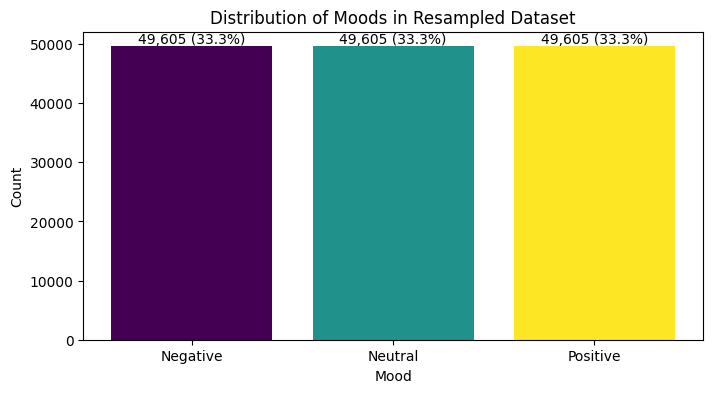

In [313]:
mood_mapping = {0: 'Neutral', 1: 'Positive', 2: 'Negative'}
r_df = pd.DataFrame({'Mood': y_train_resampled})
r_df['Mood'] = r_df['Mood'].map(mood_mapping)

mood_counts = r_df['Mood'].value_counts().sort_index()
colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(mood_counts)))

plt.figure(figsize=(8, 4))
bars = plt.bar(mood_counts.index, mood_counts.values, color=colors)
plt.title('Distribution of Moods in Resampled Dataset')
plt.xlabel('Mood')
plt.ylabel('Count')

total_count = sum(mood_counts.values)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height, f'{int(height):,} ({height/total_count:.1%})',
             ha='center', va='bottom')

plt.show()


#  Model training and evaluation using tf-idf method

In [236]:
!pip install scikit-plot

In [322]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = X_train_tf

In [323]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)
y_pred_log_reg = log_reg.predict(X_test_tf)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_log_reg))


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93     12401
           1       0.89      0.80      0.84      5248
           2       0.89      0.53      0.67      1043

    accuracy                           0.89     18692
   macro avg       0.89      0.77      0.81     18692
weighted avg       0.89      0.89      0.89     18692



In [324]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train_tfidf, y_train)
y_pred_random_forest = random_forest.predict(X_test_tfidf)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_random_forest))


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96     12401
           1       0.93      0.90      0.92      5248
           2       0.90      0.73      0.80      1043

    accuracy                           0.94     18692
   macro avg       0.93      0.87      0.89     18692
weighted avg       0.94      0.94      0.94     18692



# Model Performance For Imbalanced Data

Execution time: 347.59 s
Training accuracy Score :  0.9499580015455431
Testing accuracy Score :  0.942756259362294

Random Forest Results:
Accuracy: 0.9428
Precision: 0.9423
Recall: 0.9428
F1 Score: 0.9416
ROC AUC Score: 0.9750
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     12401
           1       0.93      0.91      0.92      5248
           2       0.92      0.71      0.80      1043

    accuracy                           0.94     18692
   macro avg       0.93      0.86      0.89     18692
weighted avg       0.94      0.94      0.94     18692



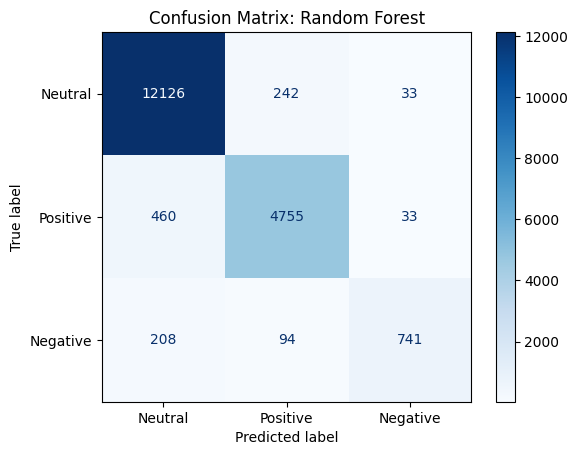

Execution time: 4.72 s
Training accuracy Score :  0.8199442260524813
Testing accuracy Score :  0.8967472715600256

Logistic Regression Results:
Accuracy: 0.8967
Precision: 0.8964
Recall: 0.8967
F1 Score: 0.8931
ROC AUC Score: 0.9545
              precision    recall  f1-score   support

           0       0.90      0.96      0.93     12401
           1       0.89      0.81      0.85      5248
           2       0.90      0.55      0.68      1043

    accuracy                           0.90     18692
   macro avg       0.90      0.77      0.82     18692
weighted avg       0.90      0.90      0.89     18692



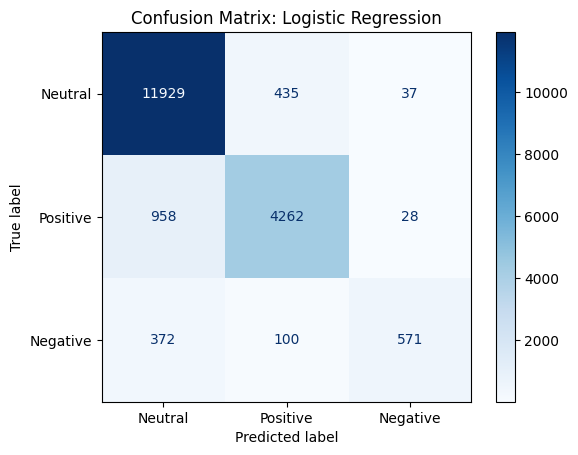

Execution time: 27.59 s
Training accuracy Score :  0.7898800524140711
Testing accuracy Score :  0.8897924245666595

XGBoost Results:
Accuracy: 0.8898
Precision: 0.8928
Recall: 0.8898
F1 Score: 0.8834
ROC AUC Score: 0.9425
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     12401
           1       0.92      0.77      0.84      5248
           2       0.91      0.46      0.61      1043

    accuracy                           0.89     18692
   macro avg       0.90      0.74      0.79     18692
weighted avg       0.89      0.89      0.88     18692



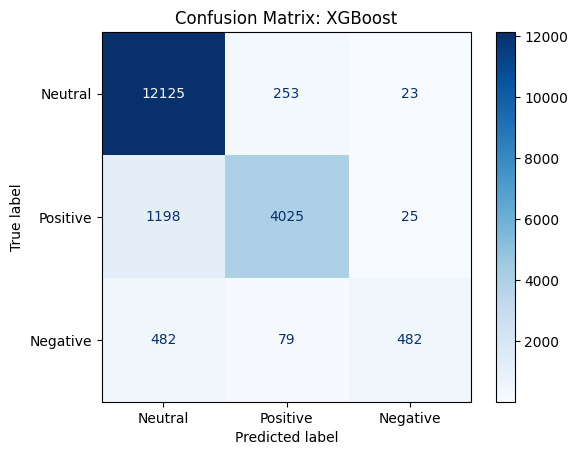

In [315]:
# Define the models
display_labels = ['Neutral', 'Positive', 'Negative']

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(multi_class='multinomial', max_iter=500, class_weight='balanced',random_state=42),
    "XGBoost": XGBClassifier(objective='multi:softmax', num_class=3,random_state=42)
}

# Train, predict, and evaluate each model
for model_name, model in models.items():
    time_start = time.time()  
    model.fit(X_train_tf, y_train)
    y_pred = model.predict(X_test_tf)
    end_time = time.time() 
    execution_time = end_time - time_start
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_tf), multi_class='ovr')

    print(f"Execution time: {execution_time:.2f} s")    
    print("Training accuracy Score : ",model.score(X_train_resampled,y_train_resampled))
    print("Testing accuracy Score : ", accuracy_score(y_test,y_pred))
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

# Model Performance For Balanced Data

Execution time: 541.36 s
Training accuracy Score :  0.993764069482243
Testing accuracy Score :  0.934249946501177

Random Forest Results:
Accuracy: 0.9342
Precision: 0.9333
Recall: 0.9342
F1 Score: 0.9333
ROC AUC Score: 0.9779
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     12401
           1       0.93      0.90      0.91      5248
           2       0.84      0.72      0.78      1043

    accuracy                           0.93     18692
   macro avg       0.90      0.86      0.88     18692
weighted avg       0.93      0.93      0.93     18692



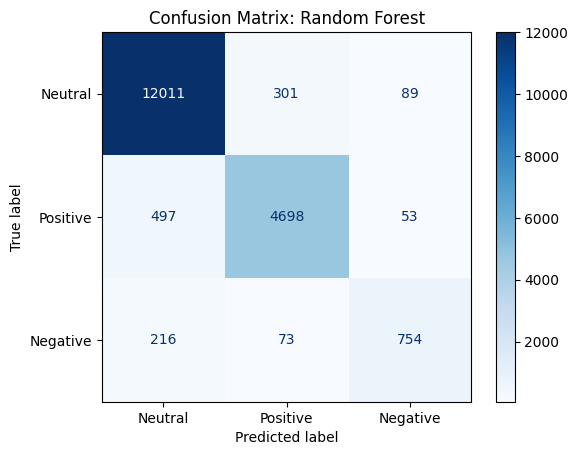

Execution time: 11.50 s
Training accuracy Score :  0.9236165709101906
Testing accuracy Score :  0.8859405093087952

Logistic Regression Results:
Accuracy: 0.8859
Precision: 0.8952
Recall: 0.8859
F1 Score: 0.8890
ROC AUC Score: 0.9531
              precision    recall  f1-score   support

           0       0.95      0.90      0.92     12401
           1       0.84      0.86      0.85      5248
           2       0.58      0.81      0.67      1043

    accuracy                           0.89     18692
   macro avg       0.79      0.86      0.82     18692
weighted avg       0.90      0.89      0.89     18692



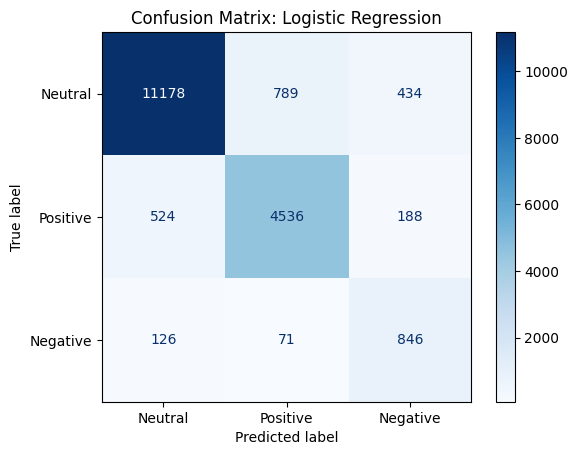

Execution time: 71.30 s
Training accuracy Score :  0.8942243725430904
Testing accuracy Score :  0.8838005563877595

XGBoost Results:
Accuracy: 0.8838
Precision: 0.8844
Recall: 0.8838
F1 Score: 0.8822
ROC AUC Score: 0.9366
              precision    recall  f1-score   support

           0       0.90      0.95      0.92     12401
           1       0.91      0.78      0.84      5248
           2       0.63      0.64      0.63      1043

    accuracy                           0.88     18692
   macro avg       0.81      0.79      0.80     18692
weighted avg       0.88      0.88      0.88     18692



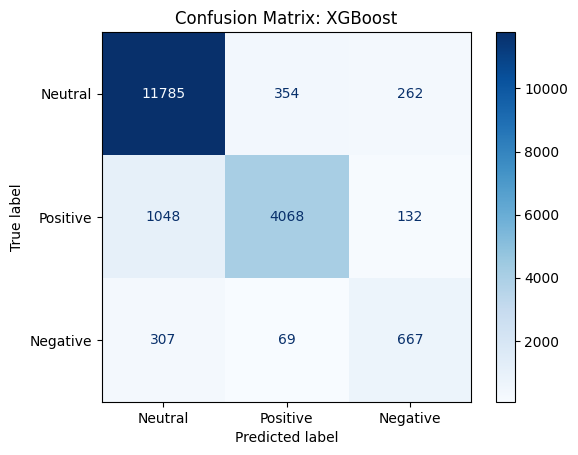

In [319]:
# Define the models
display_labels = ['Neutral', 'Positive', 'Negative']

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(multi_class='multinomial', max_iter=10000, class_weight='balanced',random_state=42),
    "XGBoost": XGBClassifier(objective='multi:softmax', num_class=3, use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Train, predict, and evaluate each model
for model_name, model in models.items():
    time_start = time.time()  
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_tf)
    end_time = time.time() 
    execution_time = end_time - time_start
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_tf), multi_class='ovr')
    
    print(f"Execution time: {execution_time:.2f} s")    
    print("Training accuracy Score : ",model.score(X_train_resampled,y_train_resampled))
    print("Testing accuracy Score : ", accuracy_score(y_test,y_pred))
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.show()

# Cross-validation

Cross-validation is a technique used to evaluate the performance of a model by splitting the data into multiple folds.
This process helps in evaluating the performance of the model while handling class imbalance and ensuring reproducibility through the use of random states.

Model training and evaluation, where in each fold, the model is trained on the training set and evaluated on the test set. This process is repeated for all folds, and the performance metrics are averaged to get an overall assessment.

Random Forest Cross-validation

In [325]:
# Define the pipeline with Random Forest
rf_model = RandomForestClassifier(random_state=42)
SMOTE_pipeline_rf = make_pipeline(smote, rf_model)

def model_cv(splits, X, Y, pipeline, average_method):
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy, precision, recall, f1 = [], [], [], []
    
    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # Fit the model on the training set
        model_fit = pipeline.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model_fit.predict(X_test)
        
        # Calculate scores
        accuracy.append(model_fit.score(X_test, y_test) * 100)
        precision.append(precision_score(y_test, y_pred, average=average_method) * 100)
        recall.append(recall_score(y_test, y_pred, average=average_method) * 100)
        f1.append(f1_score(y_test, y_pred, average=average_method) * 100)
        
        # Print individual fold scores for debugging purposes
        print('              negative    neutral     positive')
        print('precision:', precision_score(y_test, y_pred, average=None))
        print('recall:   ', recall_score(y_test, y_pred, average=None))
        print('f1 score: ', f1_score(y_test, y_pred, average=None))
        print('-'*50)
    
    # Print overall scores
    print("accuracy: %.2f%%" % np.mean(accuracy))
    print("precision: %.2f%%" % np.mean(precision))
    print("recall: %.2f%%" % np.mean(recall))
    print("f1 score: %.2f%%" % np.mean(f1))

# Perform cross-validation
model_cv(5, X_train_resampled, y_train_resampled, SMOTE_pipeline_rf, 'macro')


              negative    neutral     positive
precision: [0.94995045 0.96952596 0.98841543]
recall:    [0.96613245 0.95242415 0.9890132 ]
f1 score:  [0.95797311 0.96089897 0.98871423]
--------------------------------------------------
              negative    neutral     positive
precision: [0.9479723  0.9719078  0.98822345]
recall:    [0.96603165 0.95202097 0.98961798]
f1 score:  [0.95691678 0.9618616  0.98892023]
--------------------------------------------------
              negative    neutral     positive
precision: [0.95142942 0.9734185  0.9889425 ]
recall:    [0.96945872 0.95232335 0.99163391]
f1 score:  [0.96035946 0.96275539 0.99028638]
--------------------------------------------------
              negative    neutral     positive
precision: [0.95229612 0.97549676 0.98753268]
recall:    [0.96986191 0.95504485 0.99002117]
f1 score:  [0.96099875 0.96516247 0.98877536]
--------------------------------------------------
              negative    neutral     positive
precision

Logistic Regression Cross-validation

In [15]:
# Define the pipeline with Logistic Regression
log_reg_model = LogisticRegression(random_state=42, max_iter=10000)
SMOTE_pipeline_log_reg = make_pipeline(smote, log_reg_model)

def model_cv(splits, X, Y, pipeline, average_method):
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy, precision, recall, f1 = [], [], [], []
    
    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # Fit the model on the training set
        model_fit = pipeline.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model_fit.predict(X_test)
        
        # Calculate scores
        accuracy.append(model_fit.score(X_test, y_test) * 100)
        precision.append(precision_score(y_test, y_pred, average=average_method) * 100)
        recall.append(recall_score(y_test, y_pred, average=average_method) * 100)
        f1.append(f1_score(y_test, y_pred, average=average_method) * 100)
        
        # Print individual fold scores for debugging purposes
        print('              negative    neutral     positive')
        print('precision:', precision_score(y_test, y_pred, average=None))
        print('recall:   ', recall_score(y_test, y_pred, average=None))
        print('f1 score: ', f1_score(y_test, y_pred, average=None))
        print('-'*50)
    
    # Print overall scores
    print("accuracy: %.2f%%" % np.mean(accuracy))
    print("precision: %.2f%%" % np.mean(precision))
    print("recall: %.2f%%" % np.mean(recall))
    print("f1 score: %.2f%%" % np.mean(f1))

# Perform cross-validation
model_cv(5, X_train_resampled, y_train_resampled, SMOTE_pipeline_log_reg, 'macro')

              negative    neutral     positive
precision: [0.93846304 0.95240934 0.9767397 ]
recall:    [0.94094065 0.93732277 0.98963427]
f1 score:  [0.93970021 0.94480583 0.9831447 ]
--------------------------------------------------
              negative    neutral     positive
precision: [0.94186615 0.95600239 0.97422829]
recall:    [0.94260291 0.93917465 0.99061308]
f1 score:  [0.94223439 0.94751381 0.98235237]
--------------------------------------------------
              negative    neutral     positive
precision: [0.94285434 0.95447332 0.97306656]
recall:    [0.94054953 0.94103266 0.98914638]
f1 score:  [0.94170052 0.94770534 0.98104059]
--------------------------------------------------
              negative    neutral     positive
precision: [0.93943525 0.95734266 0.97230769]
recall:    [0.94347741 0.93702943 0.98875526]
f1 score:  [0.94145199 0.94707714 0.9804625 ]
--------------------------------------------------
              negative    neutral     positive
precision

XGBoost cross validation

In [13]:
# Define the pipeline with XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
SMOTE_pipeline_xgb = make_pipeline(smote, xgb_model)

def model_cv(splits, X, Y, pipeline, average_method):
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy, precision, recall, f1 = [], [], [], []
    
    for train_index, test_index in kfold.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # Fit the model on the training set
        model_fit = pipeline.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model_fit.predict(X_test)
        
        # Calculate scores
        accuracy.append(model_fit.score(X_test, y_test) * 100)
        precision.append(precision_score(y_test, y_pred, average=average_method) * 100)
        recall.append(recall_score(y_test, y_pred, average=average_method) * 100)
        f1.append(f1_score(y_test, y_pred, average=average_method) * 100)
        
        # Print individual fold scores for debugging purposes
        print('              negative    neutral     positive')
        print('precision:', precision_score(y_test, y_pred, average=None))
        print('recall:   ', recall_score(y_test, y_pred, average=None))
        print('f1 score: ', f1_score(y_test, y_pred, average=None))
        print('-'*50)
    
    # Print overall scores
    print("accuracy: %.2f%%" % np.mean(accuracy))
    print("precision: %.2f%%" % np.mean(precision))
    print("recall: %.2f%%" % np.mean(recall))
    print("f1 score: %.2f%%" % np.mean(f1))

# Perform cross-validation
model_cv(5, X_train_resampled, y_train_resampled, SMOTE_pipeline_xgb, 'macro')


              negative    neutral     positive
precision: [0.81702561 0.95904397 0.92529463]
recall:    [0.94221179 0.80825266 0.9290045 ]
f1 score:  [0.87516462 0.87721532 0.92714585]
--------------------------------------------------
              negative    neutral     positive
precision: [0.82206133 0.95854445 0.9274571 ]
recall:    [0.9436785  0.81400352 0.93008702]
f1 score:  [0.87868166 0.88038075 0.9287702 ]
--------------------------------------------------
              negative    neutral     positive
precision: [0.82482877 0.95641202 0.92647345]
recall:    [0.94201623 0.81537258 0.93145595]
f1 score:  [0.87953622 0.88027872 0.92895802]
--------------------------------------------------
              negative    neutral     positive
precision: [0.8249829  0.95700655 0.924842  ]
recall:    [0.9435752  0.81402171 0.93008702]
f1 score:  [0.88030289 0.87974215 0.9274571 ]
--------------------------------------------------
              negative    neutral     positive
precision

Based on these evaluations, we recommend using the Random Forest model for our text classification task due to highest accuracy and balanced performance across all classes, though it has some difficulty with the Negative class. Consider further tuning the Random Forest model or exploring ensemble methods to improve performance, especially for the Negative class OR review the pre-processing steps to ensure the data for the Negative class is well represented and correctly labelled, as this might improve model performance.
